In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [52]:

TRAIN_PATH = '/kaggle/input/fer-stable-diffusion-dataset/ARTIFICIAL-STABLE-DIFFUSION/TRAIN'
TEST_PATH = '/kaggle/input/fer-stable-diffusion-dataset/ARTIFICIAL-STABLE-DIFFUSION/TEST'
IMG_HEIGHT = 200
IMG_WIDTH = 200
BATCH_SIZE = 64 
CLASS_LABELS  = ['Anger', 'Disgust/Sadness', 'Fear', 'Happy', 'Ambigous Emotion', 'Sadness', "Surprise"]
NUM_CLASSES = len(CLASS_LABELS)

In [38]:
from keras.preprocessing.image import ImageDataGenerator

# Set up the ImageDataGenerator with validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 20% of the data will be used for validation
)

# Set the path to your training data
TRAIN_PATH = '/kaggle/input/fer-stable-diffusion-dataset/ARTIFICIAL-STABLE-DIFFUSION/TRAIN'

# Set batch size and image dimensions
batch_size = 32
img_height = 200
img_width = 200

TEST_PATH = '/kaggle/input/fer-stable-diffusion-dataset/ARTIFICIAL-STABLE-DIFFUSION/TEST'

# Create a generator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Assuming you have subdirectories for each class
    shuffle=False  # Set to False for evaluation
)

# Create a generator for training data
train_generator = datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Assuming you have subdirectories for each class
    shuffle=True,
    subset='training',
    color_mode='grayscale'# Specify that this is the training set
)

# Create a generator for validation data
val_generator = datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Assuming you have subdirectories for each class
    shuffle=True,
    subset='validation',
    color_mode='grayscale'# Specify that this is the validation set
)

# Access dimensions of the images
img_shape = train_generator.image_shape
print("Image dimensions:", img_shape)


Found 1680 images belonging to 7 classes.
Found 5287 images belonging to 7 classes.
Found 1318 images belonging to 7 classes.
Image dimensions: (200, 200, 1)


Data Pre-processing and Data Visualization


Data Splitting

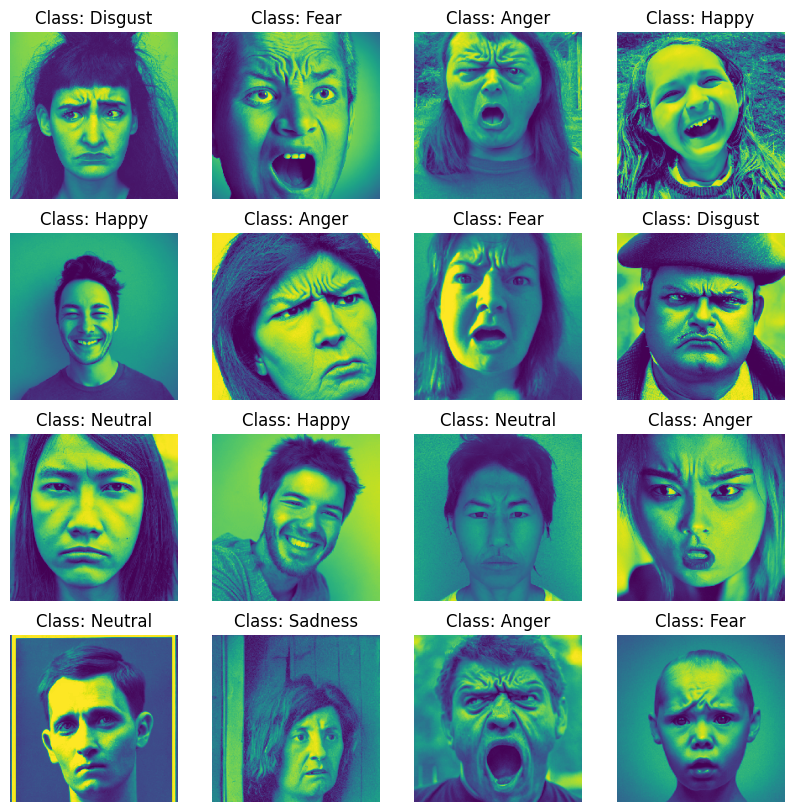

In [26]:
import matplotlib.pyplot as plt

def display_images(generator, num_rows=4, num_cols=4):
    # Get a batch of images and labels
    images, labels = next(generator)

    # Get class indices
    # Get class indices
    class_indices = generator.class_indices

    # Define the order of class labels
    CLASS_LABELS = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']

    # Map class indices to class names
    class_names = [CLASS_LABELS[index] for index in range(len(CLASS_LABELS))]

    # Now class_names contains the ordered list of class labels


    # Plot images
    plt.figure(figsize=(10, 10))
    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i])
        plt.title(f"Class: {class_names[np.argmax(labels[i])]}")
        plt.axis('off')

    plt.show()

# Display images from the train_generator
display_images(train_generator)


In [30]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical

img_size = 200

my_model = Sequential()
my_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)))  # Change the input shape to (img_size, img_size, 1)
my_model.add(MaxPooling2D((2, 2)))
my_model.add(Conv2D(64, (3, 3), activation='relu'))
my_model.add(MaxPooling2D((2, 2)))
my_model.add(Conv2D(128, (3, 3), activation='relu'))
my_model.add(MaxPooling2D((2, 2)))
my_model.add(Flatten())
my_model.add(Dense(256, activation='relu'))
my_model.add(Dropout(0.5))
my_model.add(Dense(7, activation='softmax'))

In [31]:
my_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 198, 198, 32)      320       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 99, 99, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 97, 97, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 48, 48, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 46, 46, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 23, 23, 128)      

In [32]:
from keras.optimizers import Adam

# Compile the model
my_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Train the model
history = my_model.fit(
    train_generator,
    epochs=25,  # Adjust the number of epochs as needed
    validation_data=val_generator,
)

Epoch 1/25
166/166 [==============================] - 272s 2s/step - loss: 1.8820 - accuracy: 0.2336 - val_loss: 1.8266 - val_accuracy: 0.2898
Epoch 2/25
166/166 [==============================] - 271s 2s/step - loss: 1.7686 - accuracy: 0.3185 - val_loss: 1.7215 - val_accuracy: 0.3308
Epoch 3/25
166/166 [==============================] - 270s 2s/step - loss: 1.6771 - accuracy: 0.3649 - val_loss: 1.6576 - val_accuracy: 0.3847
Epoch 4/25
166/166 [==============================] - 271s 2s/step - loss: 1.5964 - accuracy: 0.4004 - val_loss: 1.6260 - val_accuracy: 0.3968
Epoch 5/25
166/166 [==============================] - 269s 2s/step - loss: 1.5131 - accuracy: 0.4356 - val_loss: 1.5950 - val_accuracy: 0.3961
Epoch 6/25
166/166 [==============================] - 268s 2s/step - loss: 1.4443 - accuracy: 0.4660 - val_loss: 1.5686 - val_accuracy: 0.4165
Epoch 7/25
166/166 [==============================] - 268s 2s/step - loss: 1.3596 - accuracy: 0.4967 - val_loss: 1.5610 - val_accuracy: 0.4112

Evaluating 

In [52]:
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input

# Load the custom image
img_path = '/kaggle/input/human-face-emotions/data/Happy/GettyImages-871518740.jpg'
# Resize the image to match the input size of your model
img = image.load_img(img_path, target_size=(img_size, img_size), grayscale=True)

# Convert the image to a NumPy array
img_array = image.img_to_array(img)

# For color images, you might need to expand dimensions and preprocess_input
# img_array = np.expand_dims(img_array, axis=0)
# img_array = preprocess_input(img_array)

# For grayscale images, add batch dimension
img_array = np.expand_dims(img_array, axis=0)

# Make Prediction
predictions = my_model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Interpret the Results
predicted_label = CLASS_LABELS[predicted_class[0]]

print("Predicted Class Label:", predicted_label)



1/1 [==============================] - 0s 38ms/step
Predicted Class Label: Sadness


In [53]:
model.save('7Emotion.h5')

Training model on another dataset

In [8]:
from keras.models import load_model

model_path = '/kaggle/input/pretrained-model-7-emotion/7Emotion.h5'

new_model = load_model(model_path)


In [40]:
NEW_TRAIN_PATH = '/kaggle/input/7-emotions-images/7 Emotions Dataset'


from keras.preprocessing.image import ImageDataGenerator

# Set up the ImageDataGenerator with validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3  # 30% of the data will be used for validation
)




# Set batch size and image dimensions
batch_size = 32
img_height = 200
img_width = 200

# Create a generator for training data
new_train_generator = datagen.flow_from_directory(
    NEW_TRAIN_PATH,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Assuming you have subdirectories for each class
    shuffle=True,
    subset='training',
    color_mode='grayscale'# Specify that this is the training set
)

TEST_PATH = '/kaggle/input/fer-stable-diffusion-dataset/ARTIFICIAL-STABLE-DIFFUSION/TEST'

# Create a generator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Assuming you have subdirectories for each class
    shuffle=False  # Set to False for evaluation
)

# Create a generator for validation data
new_val_generator = datagen.flow_from_directory(
    NEW_TRAIN_PATH,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # Assuming you have subdirectories for each class
    shuffle= False,
    subset='validation',
    color_mode='grayscale'# Specify that this is the validation set
)

# Access dimensions of the images
img_shape = new_train_generator.image_shape
print("Image dimensions:", img_shape)


Found 891 images belonging to 7 classes.
Found 1680 images belonging to 7 classes.
Found 376 images belonging to 7 classes.
Image dimensions: (200, 200, 1)


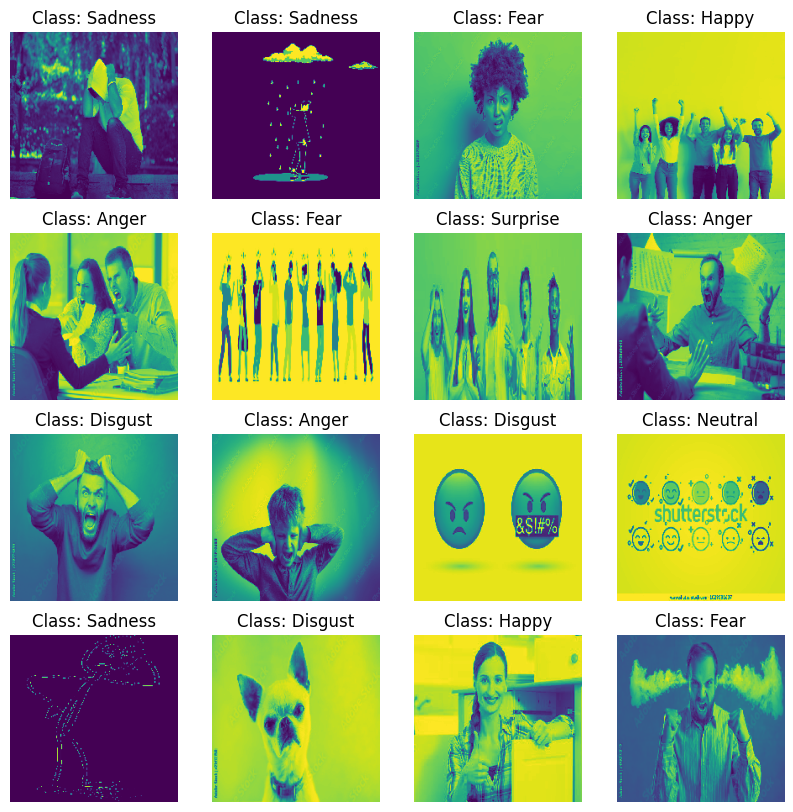

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def display_images(generator, num_rows=4, num_cols=4):
    # Get a batch of images and labels
    images, labels = next(generator)

    # Get class indices
    # Get class indices
    class_indices = generator.class_indices

    # Define the order of class labels
    CLASS_LABELS = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Surprise']

    # Map class indices to class names
    class_names = [CLASS_LABELS[index] for index in range(len(CLASS_LABELS))]

    # Now class_names contains the ordered list of class labels


    # Plot images
    plt.figure(figsize=(10, 10))
    for i in range(num_rows * num_cols):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i])
        plt.title(f"Class: {class_names[np.argmax(labels[i])]}")
        plt.axis('off')

    plt.show()

# Display images from the train_generator
display_images(new_train_generator)


In [11]:
from keras.optimizers import Adam

# Compile the model
new_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Train the model
history = new_model.fit(
    new_train_generator,
    epochs=25,  # Adjust the number of epochs as needed
    validation_data=new_val_generator,
)

Epoch 1/25
28/28 [==============================] - 57s 2s/step - loss: 1.8157 - accuracy: 0.3535 - val_loss: 1.7619 - val_accuracy: 0.3803
Epoch 2/25
28/28 [==============================] - 53s 2s/step - loss: 1.7369 - accuracy: 0.3984 - val_loss: 1.7089 - val_accuracy: 0.3830
Epoch 3/25
28/28 [==============================] - 53s 2s/step - loss: 1.6805 - accuracy: 0.3984 - val_loss: 1.6952 - val_accuracy: 0.3963
Epoch 4/25
28/28 [==============================] - 53s 2s/step - loss: 1.6162 - accuracy: 0.4501 - val_loss: 1.6291 - val_accuracy: 0.4521
Epoch 5/25
28/28 [==============================] - 54s 2s/step - loss: 1.5485 - accuracy: 0.4613 - val_loss: 1.5816 - val_accuracy: 0.4840
Epoch 6/25
28/28 [==============================] - 53s 2s/step - loss: 1.4941 - accuracy: 0.4725 - val_loss: 1.5129 - val_accuracy: 0.4920
Epoch 7/25
28/28 [==============================] - 53s 2s/step - loss: 1.4061 - accuracy: 0.4759 - val_loss: 1.4914 - val_accuracy: 0.4734
Epoch 8/25
28/28 [==

> Custom Test from User Images

Hello friend!

The images are predicted with an accuracy of ~60%. The main issue is of course, lack of good datasets. However, within the scope of our project, this works just fine to understand a task of multi class classification, in Facial Emotion Analysis. As per my understanding, the model works well with images whose focus is on faces and background is blurred, or there is not much focus on background. With that, we now realise the areas of improvement in this little project of ours. 

I enjoyed the process of importing dependencies to predicting the emotions. 


Thanks! 

~Atharv 



In [54]:
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input

# Load the custom image
img_path = '/kaggle/input/fer-stable-diffusion-dataset/ARTIFICIAL-STABLE-DIFFUSION/TEST/4/test-neutral-107.png'
# Resize the image to match the input size of your model
img_size = 200
img = image.load_img(img_path, target_size=(img_size, img_size), grayscale=True)

# Convert the image to a NumPy array
img_array = image.img_to_array(img)

# For grayscale images, add batch dimension
img_array = np.expand_dims(img_array, axis=0)

# Make Prediction
predictions = new_model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)

# Interpret the Results
predicted_label = CLASS_LABELS[predicted_class[0]]

print("Predicted Class Label:", predicted_label)



1/1 [==============================] - 0s 55ms/step
Predicted Class Label: Happy


In [55]:
model.save('Version_final_7.h5')